# Image matching dataset
- Download the dataset from Kaggle competition page: [Image Matching Challenge 2025](https://www.kaggle.com/competitions/image-matching-challenge-2025/data)
- Custom Dataset class to load the dataset
- Normalize the images with mean and std of 0.5 for all channels.

In [1]:
from data_preprocess.image_matching_dataset import ImageMatchingDataset
import torchvision.transforms as transforms
import torch

train_dataset = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                               ]))

## Initial Analysis of the dataset

## Creating descriptors for the dataset and saving them

'Total images in the training label csv:'

1945

'Total length of the dataset:'

1945

<Axes: title={'center': 'Scene distribution'}, xlabel='scene'>

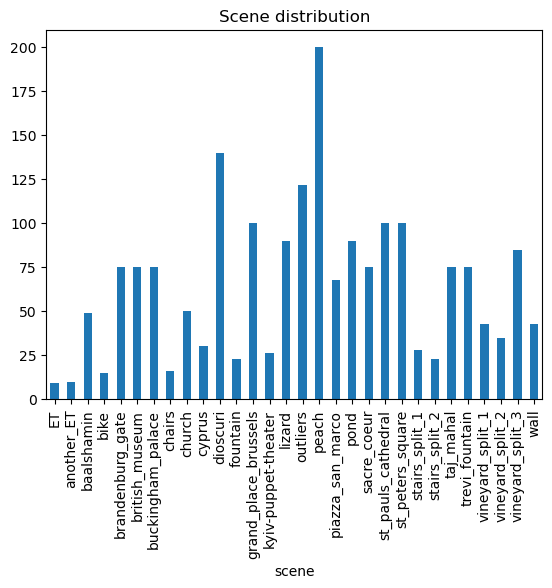

In [50]:
import pandas as pd

labels = pd.read_csv('data/train_labels.csv')
display('Total images in the training label csv:',labels.count().dataset)
display('Total length of the dataset:',train_dataset.__len__())

labels.groupby('scene').count().dataset.plot(kind='bar', title="Scene distribution")

In [63]:
display('Total outliers in the dataset',labels.groupby('scene').get_group('outliers').count().dataset)

'Total outliers in the dataset'

122

<Axes: title={'center': 'Outliers in each dataset'}, xlabel='dataset'>

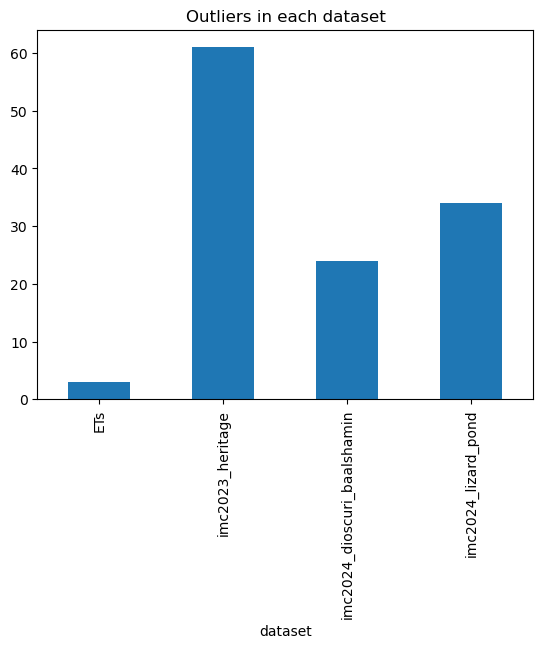

In [95]:
labels[labels['scene']=='outliers'].groupby('dataset').size().plot(kind='bar',title='Outliers in each dataset')

In [107]:
#labels.groupby(['dataset','scene']).count()
# Combination of each dataset and scene and total images for each

In [105]:
display(labels.groupby('dataset')['scene'].nunique())
display('Number of scenes per dataset')

dataset
ETs                                  3
amy_gardens                          1
fbk_vineyard                         3
imc2023_haiper                       3
imc2023_heritage                     4
imc2023_theather_imc2024_church      2
imc2024_dioscuri_baalshamin          3
imc2024_lizard_pond                  3
pt_brandenburg_british_buckingham    3
pt_piazzasanmarco_grandplace         2
pt_sacrecoeur_trevi_tajmahal         3
pt_stpeters_stpauls                  2
stairs                               2
Name: scene, dtype: int64

'Number of scenes per dataset'

# Dataset loading using dataloader and running each combination of descriptor + matcher

In [2]:
from torch.utils.data import DataLoader

DEVICE = torch.device(0 if torch.cuda.is_available() else -1)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=10)


In [12]:
from matplotlib import pyplot as plt

res = plt.imread('data/train/amy_gardens/peach_0001.png')


In [15]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
from feature_matching.lightglue_matcher import get_SIFT_features, get_DISK_features, match_features

feats0 = get_SIFT_features('data/train/amy_gardens/peach_0004.png')
feats1 = get_SIFT_features('data/train/amy_gardens/peach_0008.png')
points0, points1 = match_features(image0_features=feats0, image1_features=feats1, descriptor='sift')

print(len(points0))
print(len(points1))

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/sift_lightglue.pth" to /home/jovyan/.cache/torch/hub/checkpoints/sift_lightglue_v0-1_arxiv.pth
100%|██████████| 45.4M/45.4M [00:02<00:00, 23.5MB/s]


410
410


In [16]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
feats0 = get_DISK_features('data/train/amy_gardens/peach_0004.png')
feats1 = get_DISK_features('data/train/amy_gardens/peach_0008.png')
points0, points1 = match_features(image0_features=feats0, image1_features=feats1, descriptor='disk')

print(len(points0))
print(len(points1))

Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /home/jovyan/.cache/torch/hub/checkpoints/depth-save.pth
100%|██████████| 4.17M/4.17M [00:00<00:00, 23.4MB/s]
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/disk_lightglue.pth" to /home/jovyan/.cache/torch/hub/checkpoints/disk_lightglue_v0-1_arxiv.pth
100%|██████████| 45.4M/45.4M [00:02<00:00, 23.3MB/s]


901
901


In [108]:
feats0 = get_DISK_features('data/train/amy_gardens/peach_0004.png')
feats1 = get_DISK_features('data/train/amy_gardens/peach_0008.png')

{'keypoints': tensor([[[  12.,   88.],
         [  53.,  102.],
         [  13.,  117.],
         ...,
         [ 363., 1017.],
         [ 430., 1017.],
         [ 442., 1017.]]]), 'keypoint_scores': tensor([[ 71.3022,  73.4636,  64.8802,  ..., 102.9299,  71.9359,  63.2286]]), 'descriptors': tensor([[[-0.0957, -0.0301, -0.1847,  ...,  0.1837, -0.0297,  0.2249],
         [-0.0402,  0.0506, -0.0766,  ...,  0.1809,  0.1295, -0.0381],
         [-0.1560, -0.1329, -0.1241,  ...,  0.0572, -0.0159, -0.0085],
         ...,
         [-0.0025, -0.0835,  0.0394,  ...,  0.2082, -0.0633, -0.0250],
         [-0.1890,  0.0054, -0.0715,  ...,  0.0750, -0.0651, -0.0803],
         [-0.1525,  0.0233, -0.0048,  ..., -0.0879, -0.0159,  0.0068]]]), 'image_size': tensor([[ 576., 1024.]])}
